In [1]:
import numpy as np
import matplotlib.pyplot as plt

from uot import UOT, EntRegUOT
from uot import exact_uot, exact_entreg_uot
from uot import calc_B, calc_f, calc_g
from sinkhorn import calc_R, calc_U, calc_k_stop, sinkhorn, sinkhorn_eps
from utils import norm_inf, get_distance_matrix

import time

## Experiments

### Varying epsilon (Synthetic Data)

#### Preparation

In [2]:
# Dimension
n = 100

# Regularization
tau = np.float64(5.0)

# Mass normalization
alpha = 2.0
beta = 4.0

# Number of eps
neps = 20

In [3]:
np.random.seed(3698)

# Cost matrix
C = np.random.uniform(low=1.0, high=50.0, size=(n, n))
C = (C + C.T) / 2.0

# Marginal vectors
a = np.random.uniform(0.1, 1.0, size=n).astype(np.float64)
b = np.random.uniform(0.1, 1.0, size=n).astype(np.float64)

a = a / a.sum() * alpha
b = b / b.sum() * beta

#### Execution

In [4]:
# Original UOT problem
uot = UOT(C, a, b, tau)

# Optimal solution
f_optimal, X_optimal = exact_uot(uot)

print('Optimal:', f_optimal)

Optimal: 11.916423720378015


Epsilon 0: 1.0


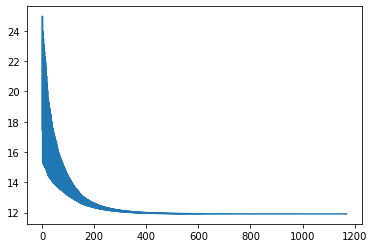

Time elapsed: 0.919914722442627
Epsilon 1: 0.6158482110660264


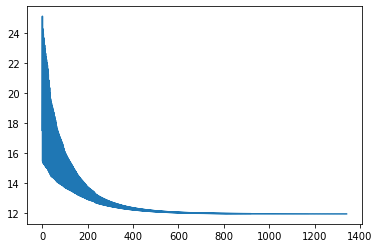

Time elapsed: 0.8769574165344238
Epsilon 2: 0.37926901907322497


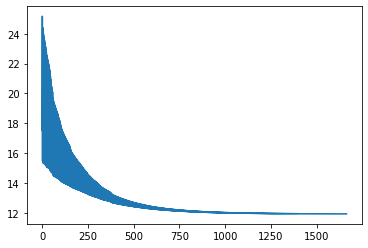

Time elapsed: 0.9132323265075684
Epsilon 3: 0.23357214690901226


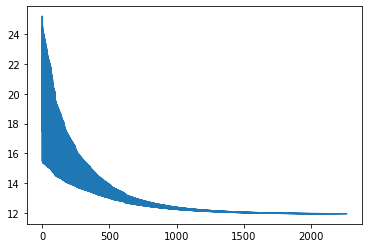

Time elapsed: 1.120974063873291
Epsilon 4: 0.14384498882876628


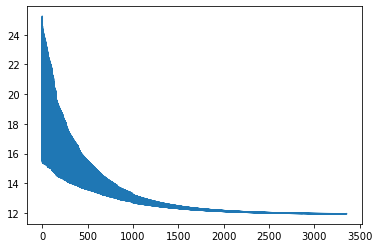

Time elapsed: 1.5267033576965332
Epsilon 5: 0.08858667904100828


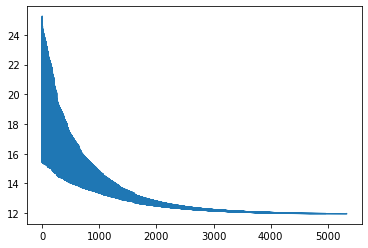

Time elapsed: 2.2441492080688477
Epsilon 6: 0.0545559478116852


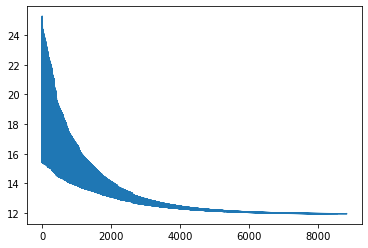

Time elapsed: 3.857332706451416
Epsilon 7: 0.033598182862837826


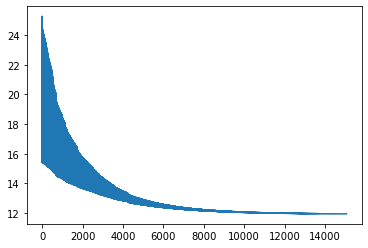

Time elapsed: 6.228986978530884
Epsilon 8: 0.0206913808111479


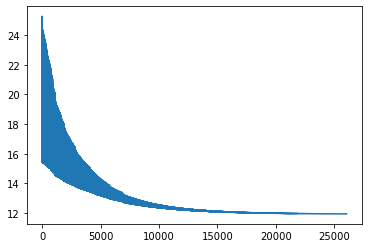

Time elapsed: 10.277040719985962
Epsilon 9: 0.012742749857031341


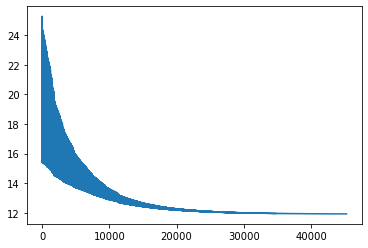

Time elapsed: 18.000280618667603
Epsilon 10: 0.007847599703514615


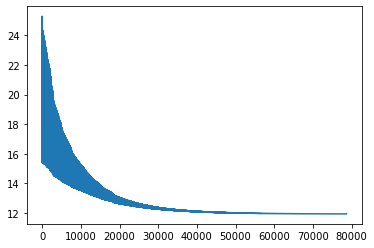

Time elapsed: 31.994346857070923
Epsilon 11: 0.004832930238571752


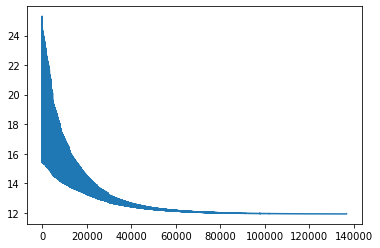

Time elapsed: 54.555256366729736
Epsilon 12: 0.002976351441631319


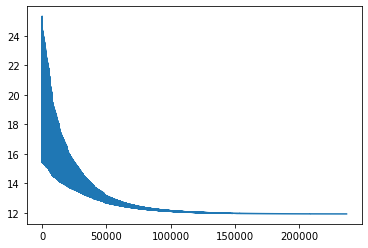

Time elapsed: 93.20660662651062
Epsilon 13: 0.0018329807108324375


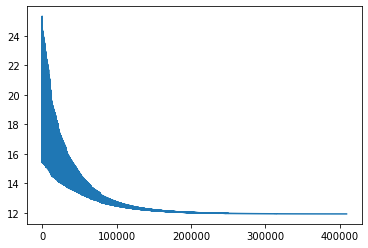

Time elapsed: 161.90014743804932
Epsilon 14: 0.0011288378916846896


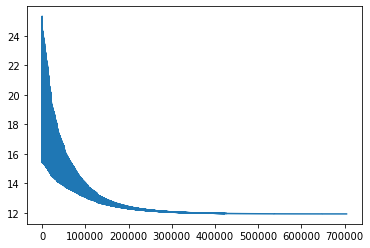

Time elapsed: 283.2280077934265
Epsilon 15: 0.0006951927961775605


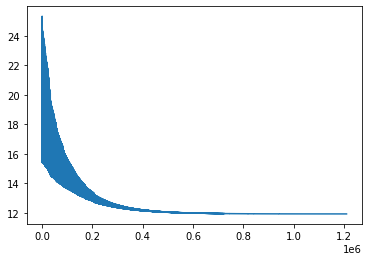

Time elapsed: 473.77930068969727
Epsilon 16: 0.00042813323987193956


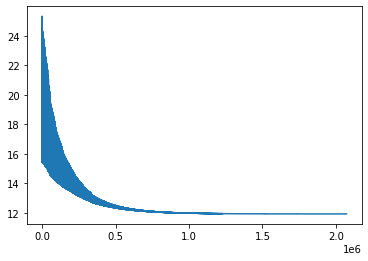

Time elapsed: 811.6480665206909
Epsilon 17: 0.0002636650898730361


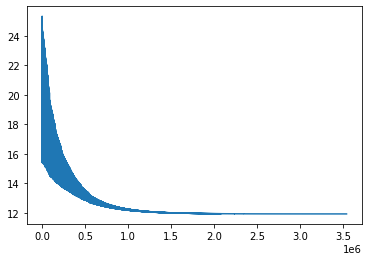

Time elapsed: 1391.740047454834
Epsilon 18: 0.00016237767391887227


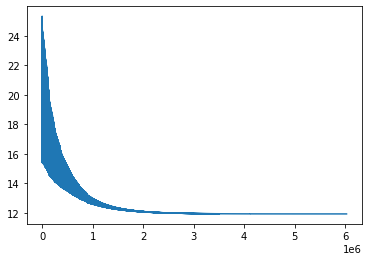

Time elapsed: 2349.3550209999084
Epsilon 19: 0.0001


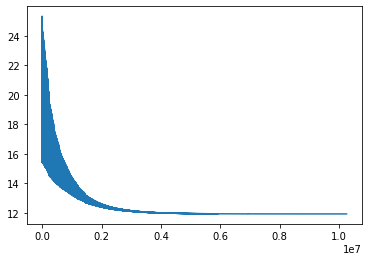

Time elapsed: 3908.8360974788666


In [5]:
# Epsilons
eps_arr = np.logspace(start=0, stop=-4, num=neps).astype(np.float64)

kfs, kcs = np.zeros((2, neps))

for i, eps in enumerate(eps_arr):
    print(f'Epsilon {i}: {eps}')
    start = time.time()

    # Entropic regularization parameter
    U = calc_U(uot, eps)
    eta = eps / U

    # Convert to Entropic Regularized UOT
    euot = EntRegUOT(C, a, b, tau, eta)

    # Sinkhorn
    _, log = sinkhorn_eps(euot, f_optimal, eps, 
                          patience=1000,
                          save_uv=False)
    
    plt.plot(log['f'][1:])
    plt.show()

    # Find k
    kfs[i] = calc_k_stop(euot, eps)
    kcs[i] = len(log['f']) - 1000

    print('Time elapsed:', time.time() - start)
    print('================')

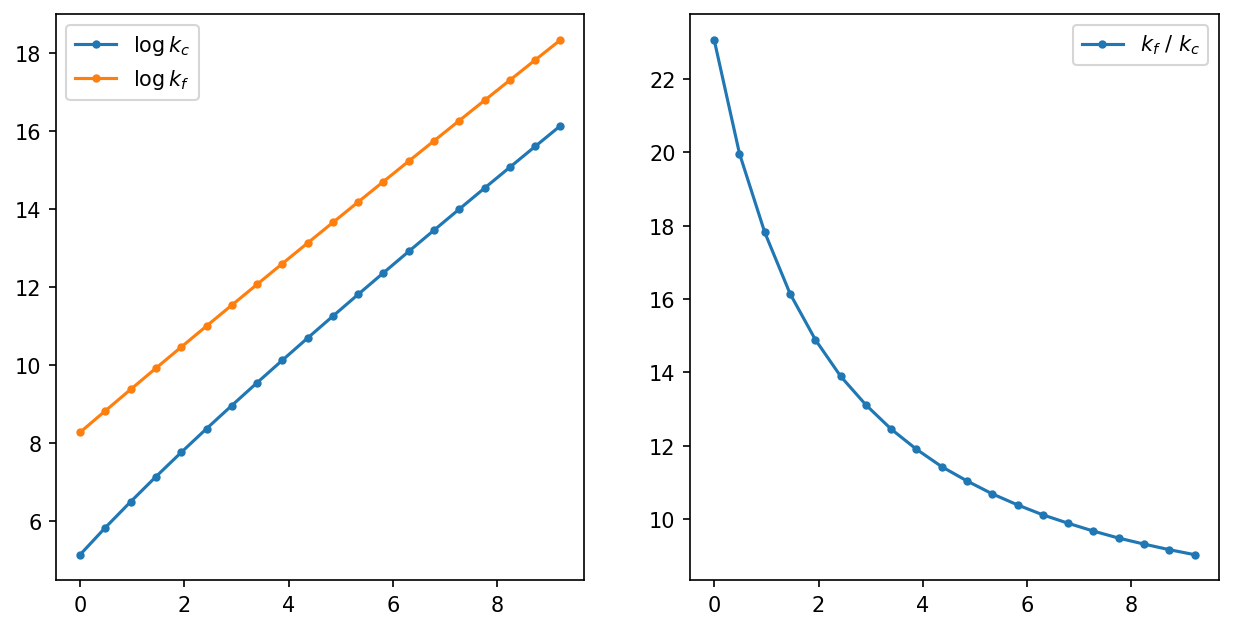

In [6]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5), dpi=150)

ax[0].plot(np.log(1/eps_arr), np.log(kcs), marker='.', label='$\log k_c$')
ax[0].plot(np.log(1/eps_arr), np.log(kfs), marker='.', label='$\log k_f$')
ax[0].legend()

ax[1].plot(np.log(1/eps_arr), kfs / kcs, marker='.', label='$k_f$ / $k_c$')
ax[1].legend()

plt.show()

### Theory check (Synthetic data)

#### Preparation

In [7]:
# Dimension
n = 100

# Regularization
tau = np.float64(1.0)
eta = np.float64(0.05)

# Number of Sinkhorn iterations
niters = 500

In [8]:
np.random.seed(3698)

# Cost matrix
C = np.random.uniform(low=1.0, high=100.0, size=(n, n)).astype(np.float64)
C = (C + C.T) / 2.0

# Marginal vectors
a = np.random.uniform(0.1, 10.0, size=n).astype(np.float64)
b = np.random.uniform(0.1, 10.0, size=n).astype(np.float64)

Unbalanced OT

In [9]:
uot = UOT(C, a, b, tau)

Solve UOT with CVXPY

In [10]:
_, X_hat = exact_uot(uot)

Entropic UOT problem

In [11]:
euot = EntRegUOT(C, a, b, tau, eta)

Solve Entropic UOT with CVXPY

In [12]:
_, u_star, v_star = exact_entreg_uot(euot)

In [13]:
X_star = calc_B(euot, u_star, v_star)
a_star = X_star.sum(-1)
b_star = X_star.sum(0)

Solve Entropic UOT with Sinkhorn iterations

In [14]:
_, log = sinkhorn(euot, niters)

#### Convergence

In [16]:
f_optimal = calc_f(uot, X_hat)
g_optimal = calc_g(euot, X_star)

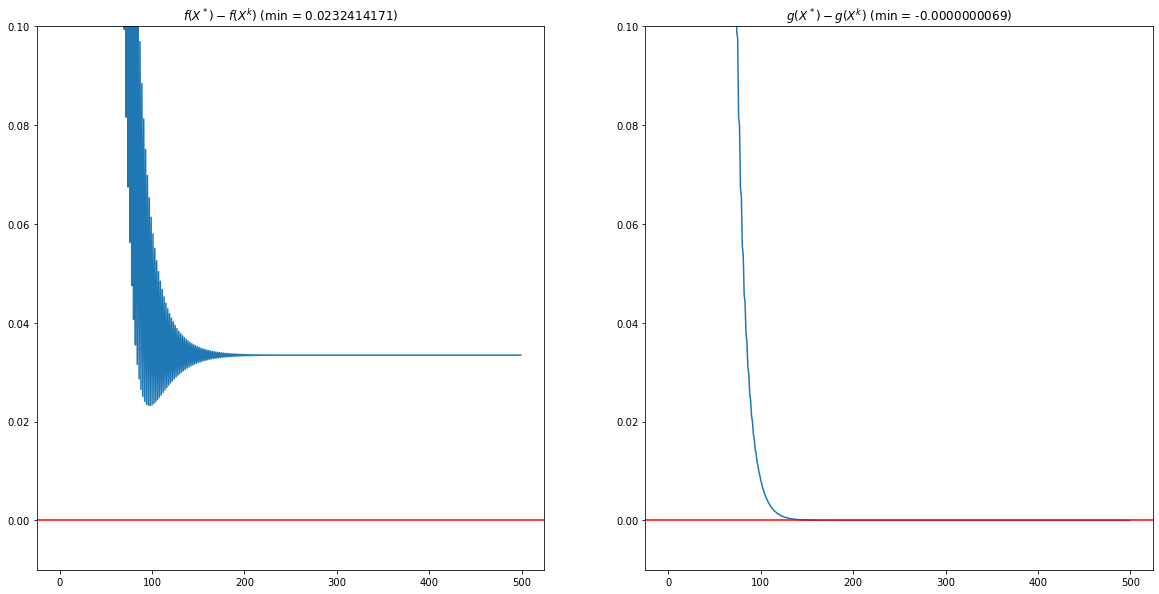

In [17]:
fs, gs = np.zeros((2, niters + 1))

for k, (uk, vk) in enumerate(zip(log['u'], log['v'])):
    Xk = calc_B(euot, uk, vk)
    fs[k] = calc_f(uot, Xk)
    gs[k] = calc_g(euot, Xk)

fig, ax = plt.subplots(1, 2, figsize=(20, 10))

ax[0].plot(fs[1:] - f_optimal)
ax[0].axhline(0, color='red')
ax[0].set_ylim(-0.01, 0.1)
ax[0].set_title(f'$f(X^*) - f(X^k)$ (min = {np.min(fs - f_optimal):.10f})')

ax[1].plot(gs[1:] - g_optimal)
ax[1].axhline(0, color='red')
ax[1].set_ylim(-0.01, 0.1)
ax[1].set_title(f'$g(X^*) - g(X^k)$ (min = {np.min(gs - g_optimal):.10f})')

plt.show()

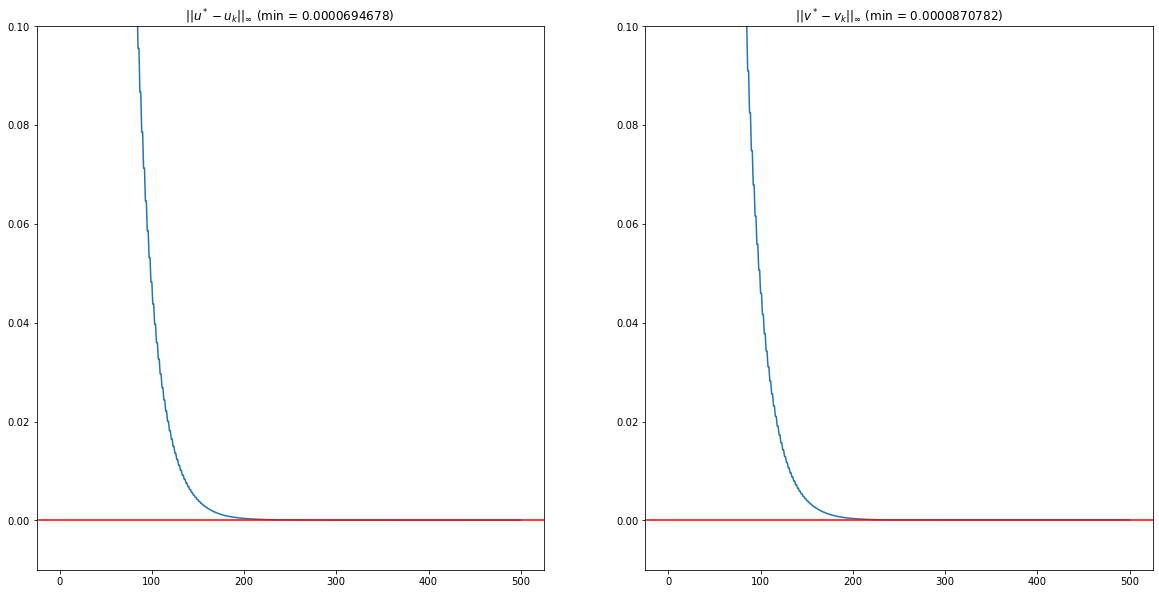

In [18]:
dus, dvs = np.zeros((2, niters + 1))

for k, (uk, vk) in enumerate(zip(log['u'], log['v'])):
    dus[k] = norm_inf(uk - u_star)
    dvs[k] = norm_inf(vk - v_star)

fig, ax = plt.subplots(1, 2, figsize=(20, 10))

ax[0].plot(range(niters + 1), dus)
ax[0].axhline(0, color='red')
ax[0].set_ylim(-0.01, 0.1)
ax[0].set_title(f'$||u^* - u_{{k}}||_\infty$ (min = {np.min(dus):.10f})')

ax[1].plot(range(niters + 1), dvs)
ax[1].axhline(0, color='red')
ax[1].set_ylim(-0.01, 0.1)
ax[1].set_title(f'$||v^* - v_{{k}}||_\infty$ (min = {np.min(dvs):.10f})')

plt.show()

#### Lemma 1

$$
\frac{u^*}{\tau} = \log(a) - \log(a^*) \\
\frac{v^*}{\tau} = \log(b) - \log(b^*)
$$

0.0014643020164619713


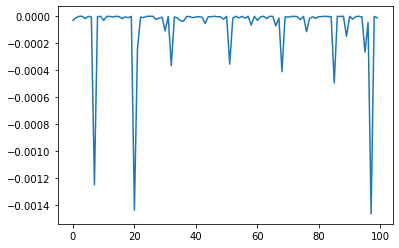

In [19]:
print(norm_inf(u_star / tau - np.log(a / a_star)))

plt.plot(u_star / tau - np.log(a / a_star))
plt.show()

0.002263160043399992


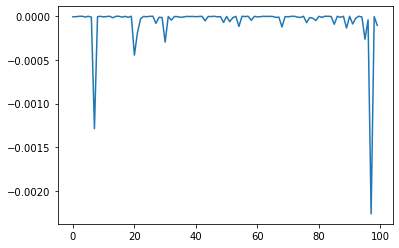

In [20]:
print(norm_inf(v_star / tau - np.log(b / b_star)))

plt.plot(v_star / tau - np.log(b / b_star))
plt.show()

#### Lemma 2

$$
\Big| \log\left( \frac{a_i^*}{a_i^k} \right) -  \frac{u_i^* - u_i^k}{\eta}\Big| \leq  \max_{1 \leq j \leq n} \frac{|v^*_j - v^{k}_j|}{\eta}
$$

$$
\Big| \log\left( \frac{b_j^*}{b_j^k} \right) -  \frac{v_j^* - v_j^k}{\eta}\Big| \leq  \max_{1 \leq i \leq n} \frac{|u^*_i - u^{k}_i|}{\eta}
$$

1.0061396160665481e-16


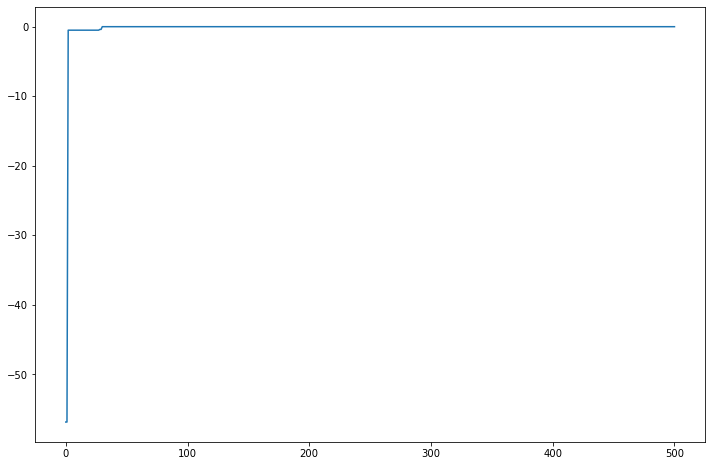

In [21]:
lhs, rhs = np.zeros((2, niters + 1))

for k, (uk, vk) in enumerate(zip(log['u'], log['v'])):
    X = calc_B(euot, uk, vk)
    ak = X.sum(-1)

    l = norm_inf(np.log(a_star / ak) - (u_star - uk) / eta)
    r = norm_inf((v_star - vk) / eta)

    lhs[k], rhs[k] = l, r

print(np.max(lhs - rhs))

plt.figure(figsize=(12, 8))
plt.plot(lhs - rhs)
plt.show()

1.7644739835898093e-14


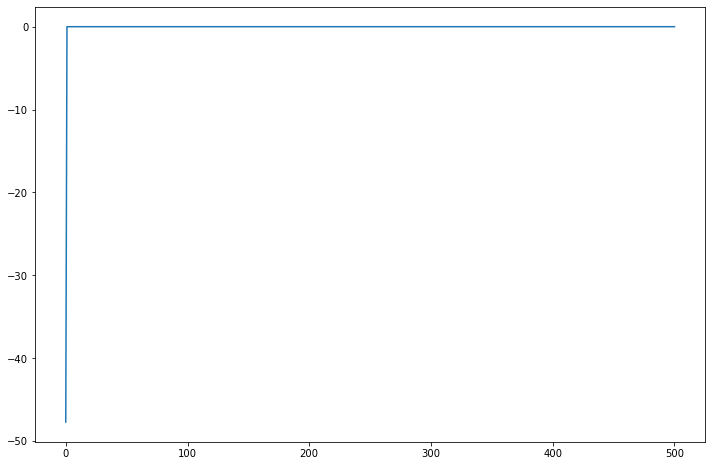

In [22]:
lhs, rhs = np.zeros((2, niters + 1))

for k, (uk, vk) in enumerate(zip(log['u'], log['v'])):
    X = calc_B(euot, uk, vk)
    bk = X.sum(0)

    l = norm_inf(np.log(b_star / bk) - (v_star - vk) / eta)
    r = norm_inf((u_star - uk) / eta)

    lhs[k], rhs[k] = l, r

print(np.max(lhs - rhs))

plt.figure(figsize=(12, 8))
plt.plot(lhs - rhs)
plt.show()

#### Lemma 3

$$
\max \{ \|u^*\|_{\infty},\|v^*\|_\infty \} \le \tau R
$$

In [23]:
R = calc_R(euot)

In [24]:
lhs = max(norm_inf(u_star), norm_inf(v_star))
rhs = tau * R
print(lhs - rhs)

-1964.6588971439326


#### Lemma 4

$$
g(X^*) + (2 \tau + \eta) x^* = \tau (\alpha + \beta) \\
f(\hat{X}) + 2 \tau \hat{x} = \tau (\alpha + \beta)
$$

In [25]:
alpha, beta = a.sum(), b.sum()

In [26]:
lhs1 = calc_g(euot, X_star) + (2 * tau + eta) * np.sum(X_star)
lhs2 = calc_f(uot, X_hat) + 2 * tau * np.sum(X_hat)
rhs = tau * (alpha + beta)
print(lhs1 - rhs)
print(lhs2 - rhs)

-0.00015325659182963136
7.65634149502148e-06


#### Theorem 1

$$
\max \{ \| u^{k} -  u^*\|_\infty, \| v^{k} -  v^*\|_\infty \} \le \Big( \frac{\tau}{\tau + \eta} \Big)^{k-1} \times \tau \times R, \;\; k \geq 1
$$

In [27]:
R = calc_R(euot)

In [28]:
lhs = np.maximum(
    np.max(np.abs(log['u'] - u_star), -1),
    np.max(np.abs(log['v'] - v_star), -1)
)
rhs = (tau / (tau + eta)) ** np.arange(niters + 1) * eta * R

lhs = lhs[1:]
rhs = rhs[:-1]

0.434


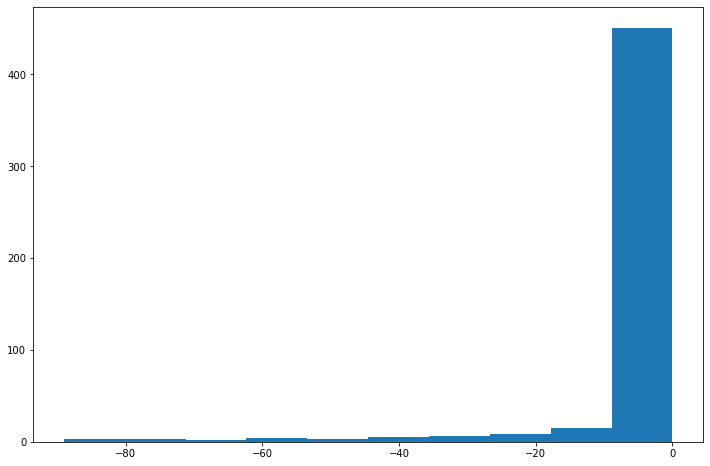

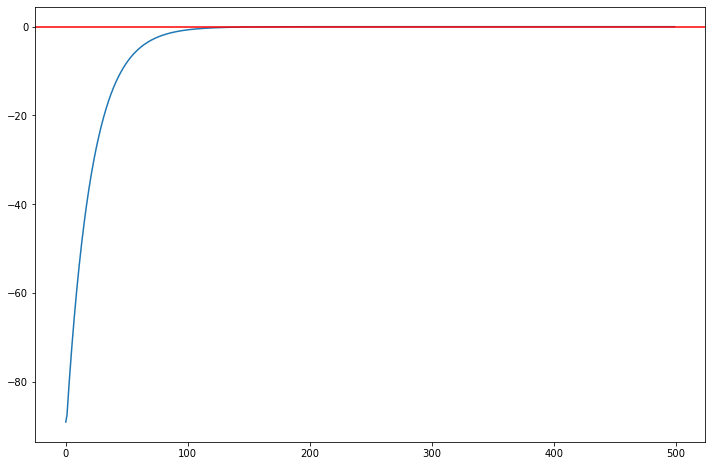

In [29]:
print((lhs > rhs).mean())

plt.figure(figsize=(12, 8))
plt.hist(lhs - rhs)
plt.show()

plt.figure(figsize=(12, 8))
plt.plot(lhs - rhs)
plt.axhline(0, c='r')
plt.show()

#### Corollary 2

$$
    \sum_{i, j = 1}^n X^*_{ij} \leq \left(\dfrac{1}{2} + \dfrac{\eta \log n}{2 \tau - 2\eta \log n}\right)(\alpha + \beta) + \dfrac{1}{6 \log n}
$$

In [30]:
lhs = X_star.sum()
rhs = (0.5 + (eta * np.log(n)) / (2 * tau - 2 * eta * np.log(n))) * (alpha + beta) + 1 / (6 * np.log(n))

print(lhs, rhs, lhs - rhs)

33.165693706296324 653.4775718518243 -620.311878145528


$$
    \sum_{i, j = 1}^n \hat{X}_{ij} \leq \dfrac{\alpha + \beta}{2}
$$

In [31]:
lhs = X_hat.sum()
rhs = (alpha + beta) / 2

print(lhs, rhs, lhs - rhs)

32.755880038991016 502.98094242313675 -470.22506238414576


Geometric

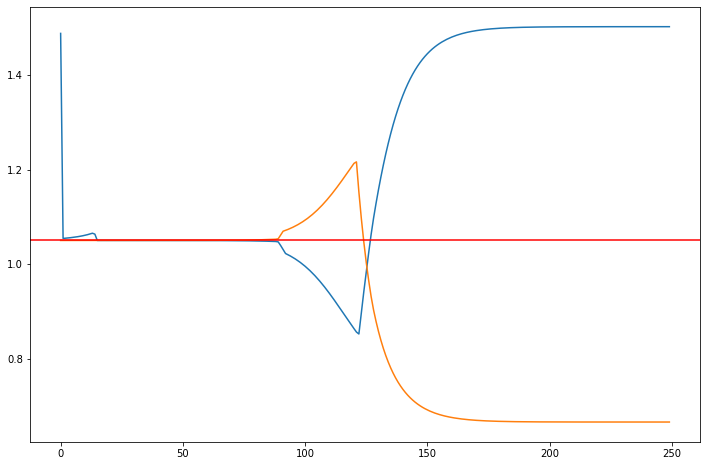

In [32]:
y1 = [
    norm_inf(log['v'][k] - v_star) / norm_inf(log['u'][k+1] - u_star)
    for k in range(0, niters - 1, 2)
]
y2 = [
    norm_inf(log['u'][k-1] - u_star) / norm_inf(log['v'][k] - v_star)
    for k in range(2, niters + 1, 2)
]

plt.figure(figsize=(12, 8))
plt.plot(y1)
plt.plot(y2)
plt.axhline((tau + eta) / tau, color='red')
plt.show()

### Varying epsilon (Real Data)

In [2]:
from mnist import load_mnist

x, y = load_mnist('data', split_type='train', download=True)

In [3]:
npairs = 10
pairs = [
    (3, 5), 
    (20562, 12428),
    (2564, 12380),
    (48485, 7605),
    (26428, 42698),
    (6152, 25061),
    (13168, 7506),
    (40816, 39370), 
    (846, 16727), 
    (31169, 7144)
]

In [4]:
n = 28

C = get_distance_matrix(n).astype(np.float64)

tau = np.float64(10.0)

Solve with CVXPY

In [5]:
fs = np.empty(npairs)
Xs = np.empty((npairs, n ** 2, n ** 2))

for i, (id1, id2) in enumerate(pairs):
    print(f'Pair [{id1:5d}] and [{id2:5d}]')
    a = x[id1].reshape(-1).astype(np.float64)
    b = x[id2].reshape(-1).astype(np.float64)

    a = a.clip(1e-6)
    b = b.clip(1e-6)

    fs[i], Xs[i] = exact_uot(UOT(C, a, b, tau))
    print('Done!')

Pair [    3] and [    5]


/home/vltanh/miniconda3/envs/ot/lib/python3.9/site-packages/cvxpy/problems/problem.py:1294: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Done!
Pair [20562] and [12428]
Done!
Pair [ 2564] and [12380]
Done!
Pair [48485] and [ 7605]
Done!
Pair [26428] and [42698]
Done!
Pair [ 6152] and [25061]
Done!
Pair [13168] and [ 7506]
Done!
Pair [40816] and [39370]
Done!
Pair [  846] and [16727]
Done!
Pair [31169] and [ 7144]
Done!


Pair [    3] and [    5]


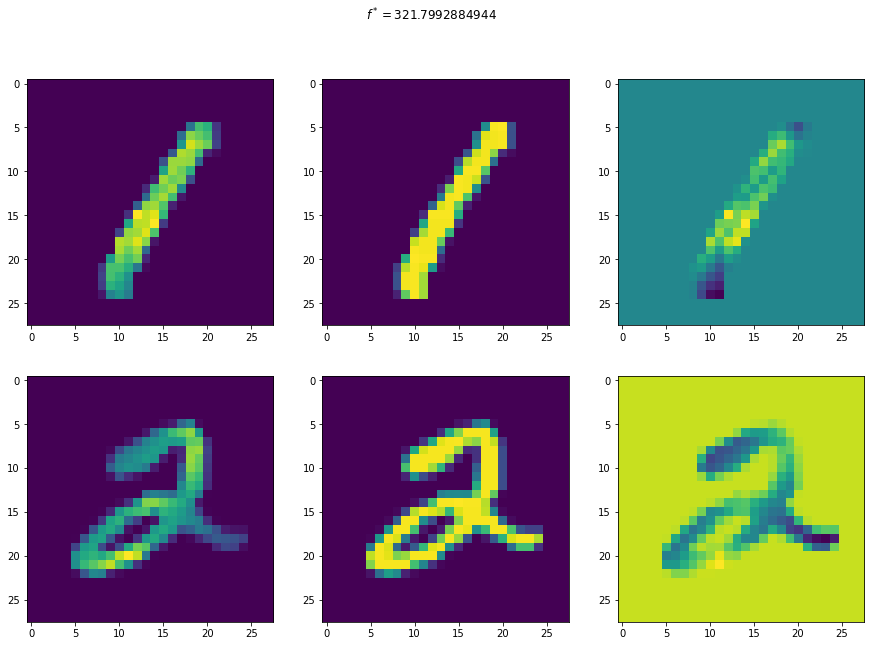

Pair [20562] and [12428]


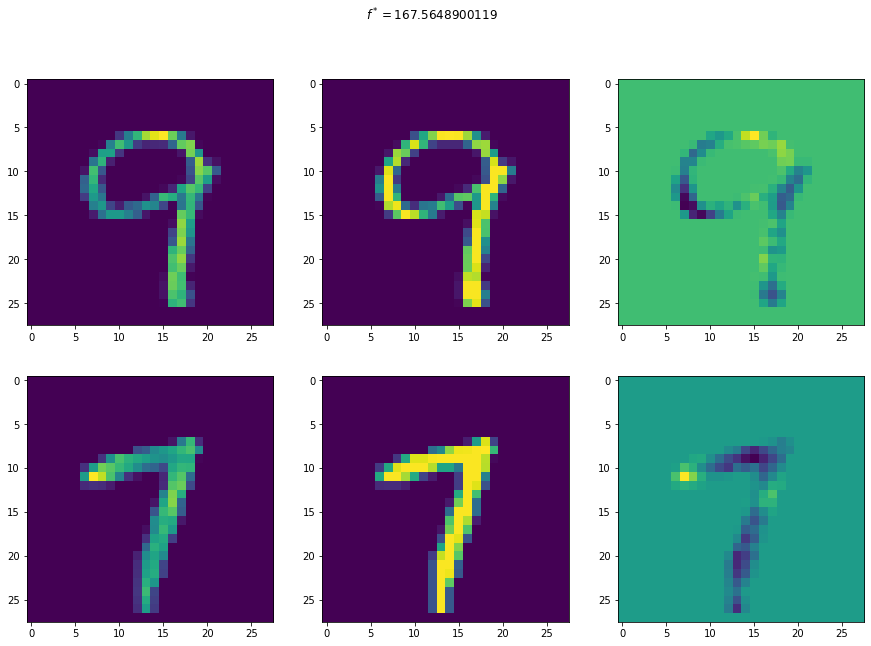

Pair [ 2564] and [12380]


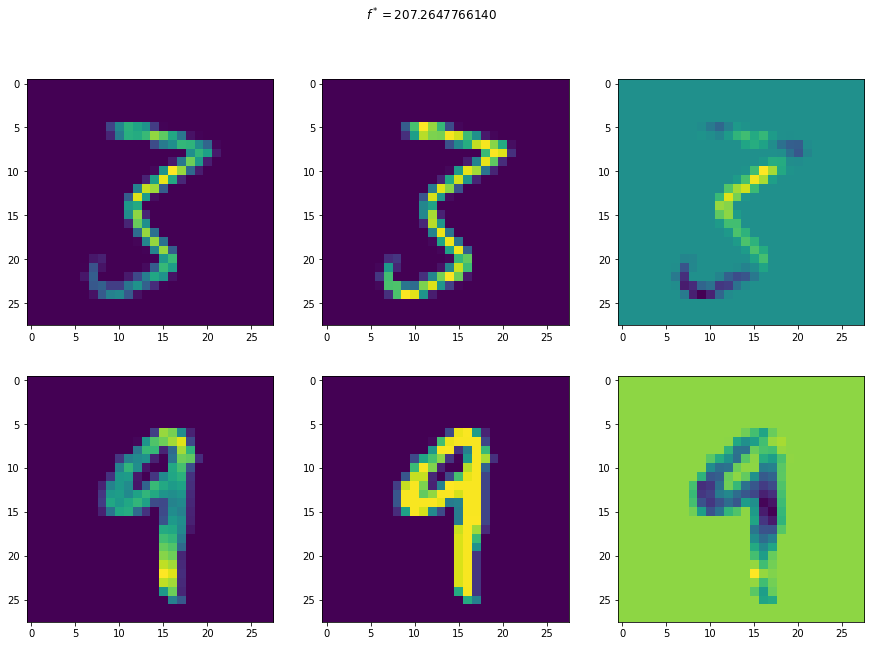

Pair [48485] and [ 7605]


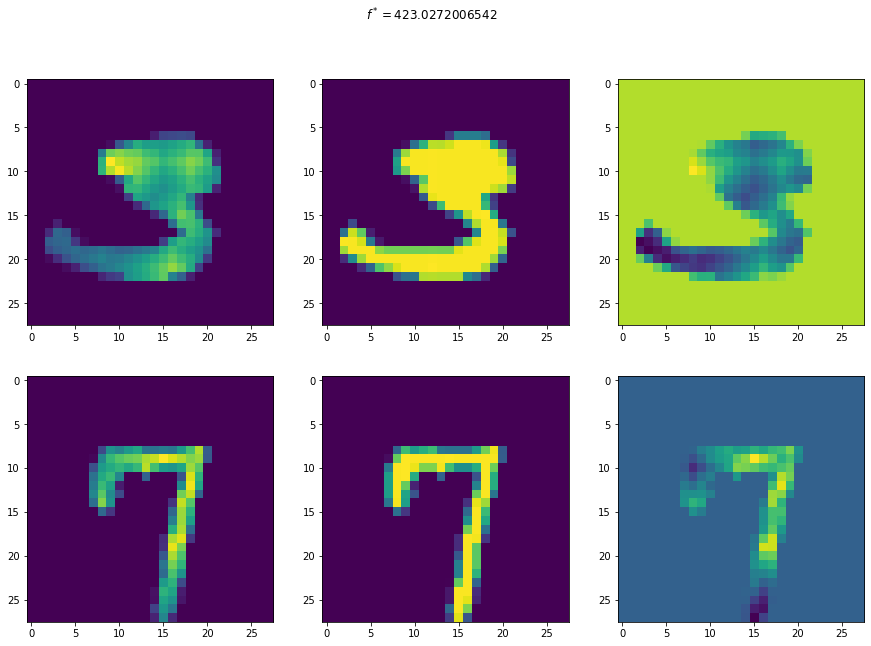

Pair [26428] and [42698]


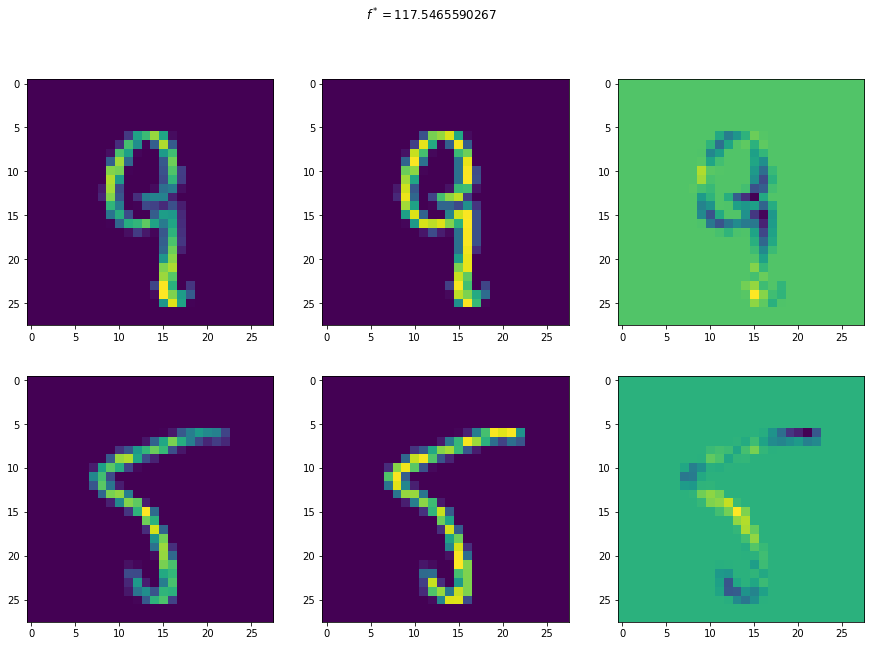

Pair [ 6152] and [25061]


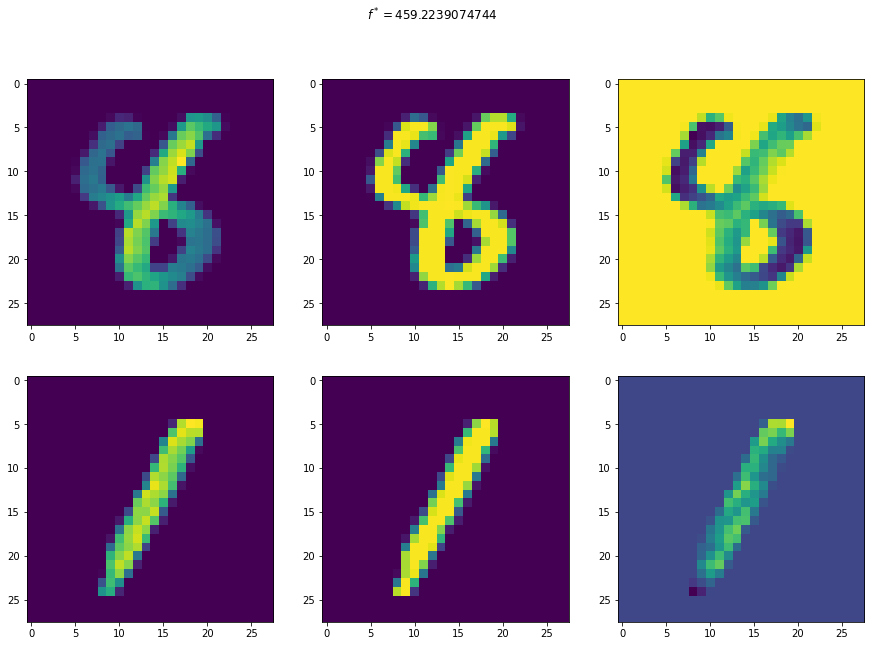

Pair [13168] and [ 7506]


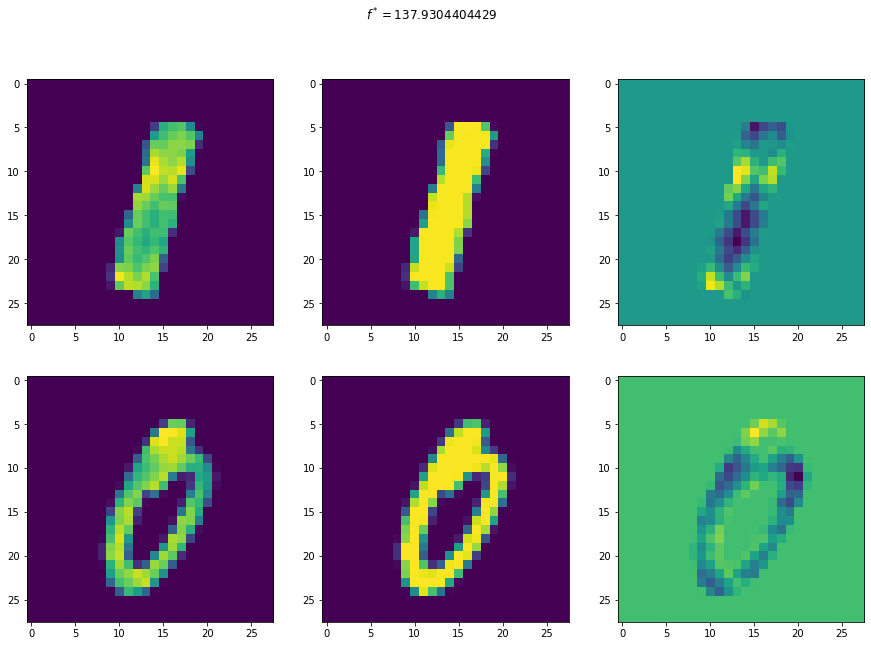

Pair [40816] and [39370]


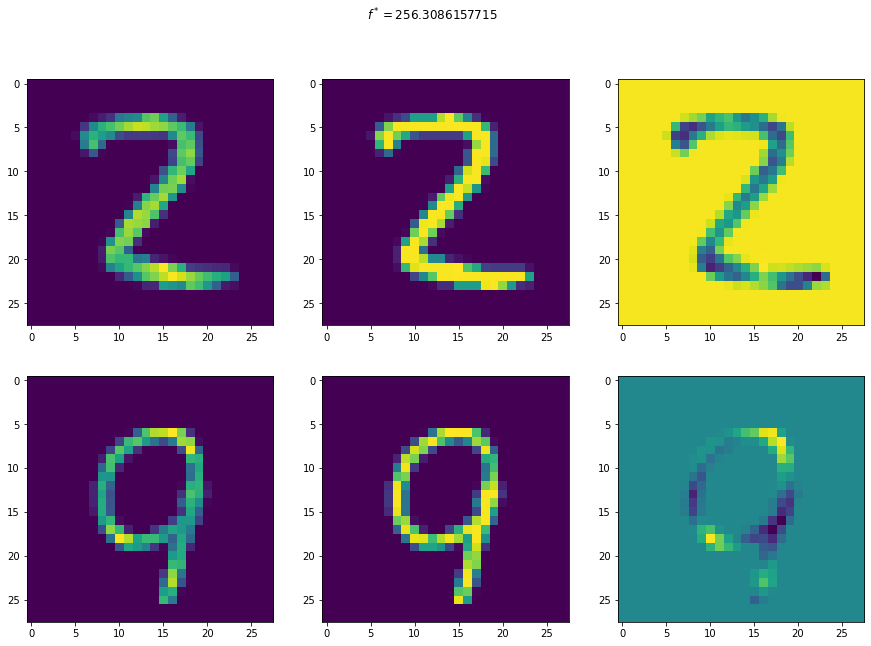

Pair [  846] and [16727]


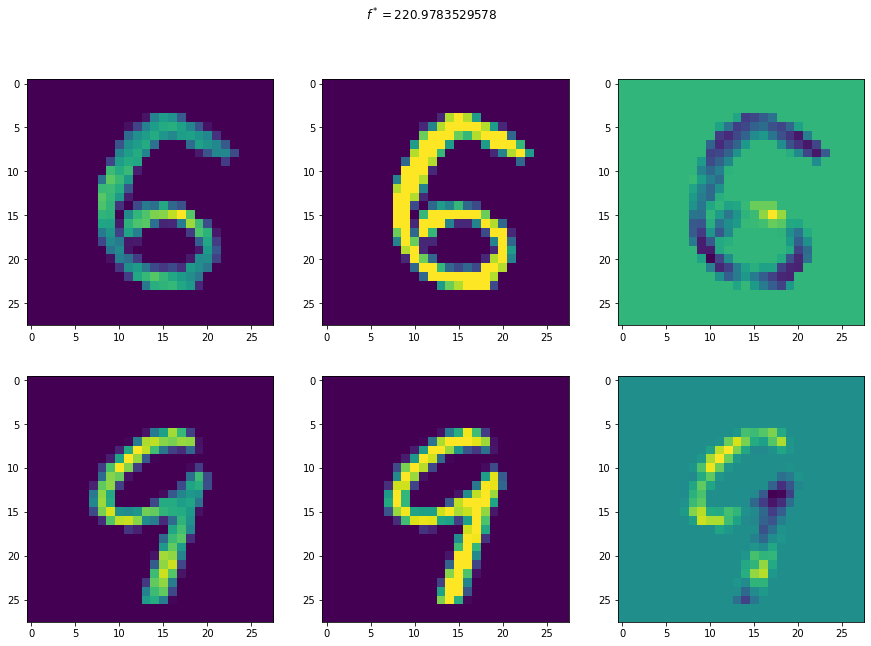

Pair [31169] and [ 7144]


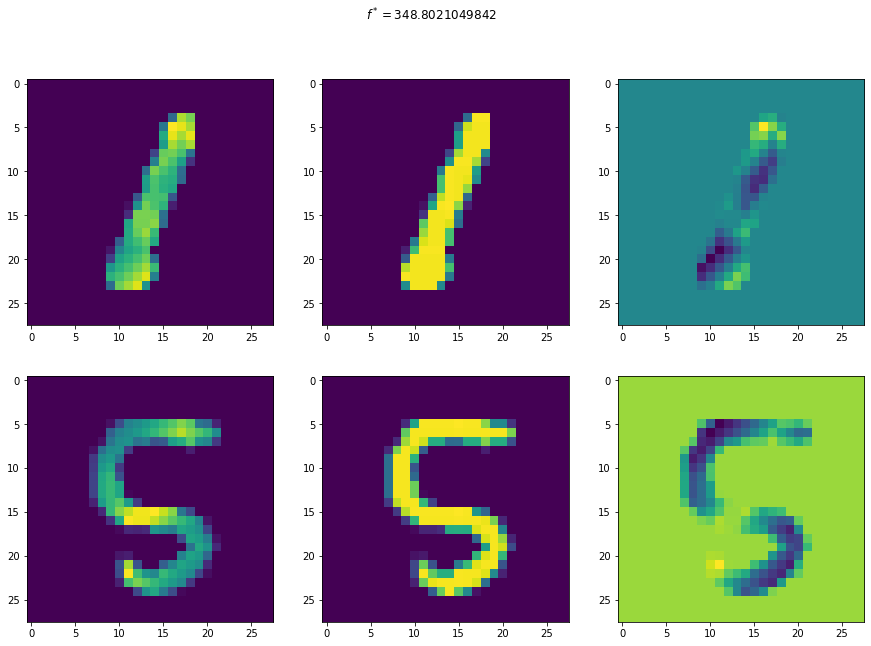

In [6]:
for i, (id1, id2) in enumerate(pairs):
    print(f'Pair [{id1:5d}] and [{id2:5d}]')
    a = x[id1].reshape(-1).astype(np.float64)
    b = x[id2].reshape(-1).astype(np.float64)

    a = a.clip(1e-6)
    b = b.clip(1e-6)

    fig, ax = plt.subplots(2, 3, figsize=(15, 10))
    
    ax[0, 0].imshow(Xs[i].sum(-1).reshape(28, 28))
    ax[0, 1].imshow(a.reshape(28, 28))
    ax[0, 2].imshow(Xs[i].sum(-1).reshape(28, 28) - a.reshape(28, 28))

    ax[1, 0].imshow(Xs[i].sum(0).reshape(28, 28))
    ax[1, 1].imshow(b.reshape(28, 28))
    ax[1, 2].imshow(Xs[i].sum(0).reshape(28, 28) - b.reshape(28, 28))

    plt.suptitle(f'$f^* = {fs[i]:.10f}$')
    plt.show()

Solve with Sinkhorn iterations

In [7]:
neps = 10
eps_arr = np.linspace(5.0, 0.5, neps).astype(np.float64)

kfs, kcs = np.zeros((2, npairs, neps), dtype=np.float64)

for i, ((id1, id2), f_optimal) in enumerate(zip(pairs, fs)):
    print(f'Pair [{id1:5d}] and [{id2:5d}]')

    a = x[id1].reshape(-1).astype(np.float64)
    b = x[id2].reshape(-1).astype(np.float64)
    
    a = a.clip(1e-6)
    b = b.clip(1e-6)

    uot = UOT(C, a, b, tau)

    for j, eps in enumerate(eps_arr):
        print(f'Epsilon {j}: {eps}')
        start = time.time()

        # Entropic regularization parameter
        U = calc_U(uot, eps)
        eta = eps / U

        # Convert to Entropic Regularized UOT
        euot = EntRegUOT(C, a, b, tau, eta)

        # Sinkhorn
        _, log = sinkhorn_eps(euot, f_optimal, eps, save_uv=False)
        
        # plt.plot(log['f'][1:])
        # plt.show()

        kfs[i][j] = calc_k_stop(euot, eps)
        kcs[i][j] = len(log['f'])

        print('Time elapsed:', time.time() - start)
        print('==================')
    print('==========================')

Pair [    3] and [    5]
Epsilon 0: 5.0
Time elapsed: 90.59064316749573
Epsilon 1: 4.5
Time elapsed: 95.04368019104004
Epsilon 2: 4.0
Time elapsed: 100.3490800857544
Epsilon 3: 3.5
Time elapsed: 106.11186289787292
Epsilon 4: 3.0
Time elapsed: 125.68248796463013
Epsilon 5: 2.5
Time elapsed: 161.41120266914368
Epsilon 6: 2.0
Time elapsed: 217.78660678863525
Epsilon 7: 1.5
Time elapsed: 316.9857246875763
Epsilon 8: 1.0
Time elapsed: 533.220885515213
Epsilon 9: 0.5
Time elapsed: 1269.6526987552643
Pair [20562] and [12428]
Epsilon 0: 5.0
Time elapsed: 44.524334192276
Epsilon 1: 4.5
Time elapsed: 45.27582883834839
Epsilon 2: 4.0
Time elapsed: 47.234691858291626
Epsilon 3: 3.5
Time elapsed: 49.900012731552124
Epsilon 4: 3.0
Time elapsed: 54.638147830963135
Epsilon 5: 2.5
Time elapsed: 66.85644030570984
Epsilon 6: 2.0
Time elapsed: 86.83843922615051
Epsilon 7: 1.5
Time elapsed: 119.37339544296265
Epsilon 8: 1.0
Time elapsed: 200.73151445388794
Epsilon 9: 0.5
Time elapsed: 549.9364578723907
Pai

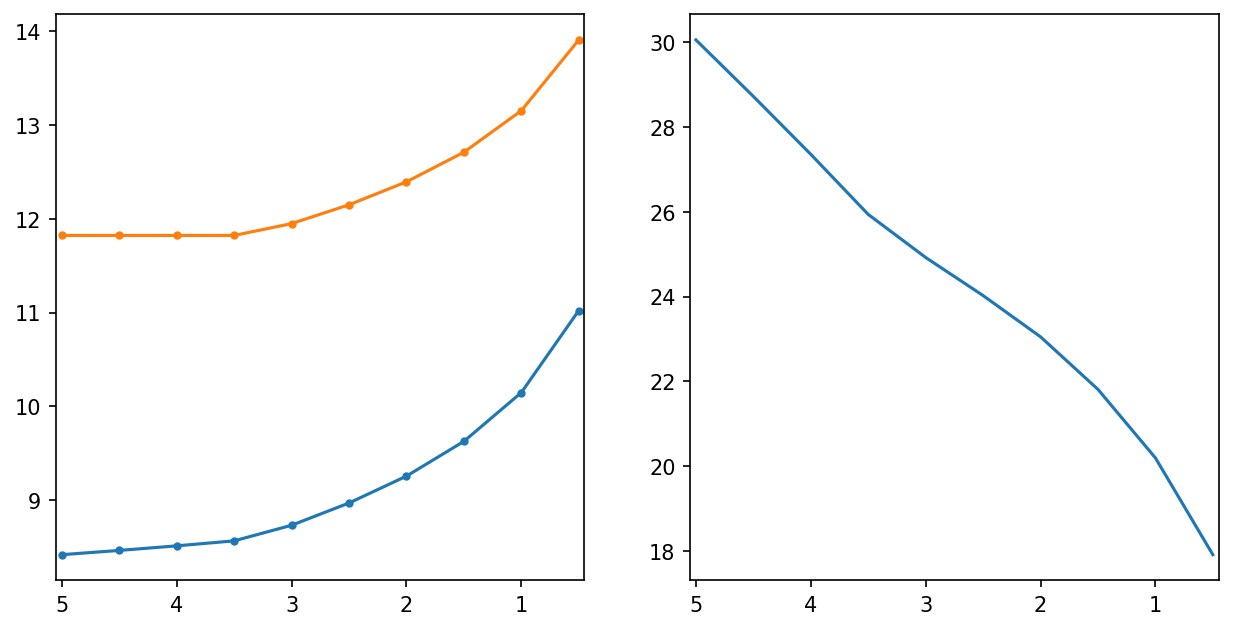

In [8]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5), dpi=150)

ax[0].plot(eps_arr, np.log(kcs.mean(0)), marker='.', label='$\log k_c$')
ax[0].plot(eps_arr, np.log(kfs.mean(0)), marker='.', label='$\log k_f$')
ax[0].set_xlim(5.0 + 0.05, 0.5 - 0.05)

ax[1].plot(eps_arr, kfs.mean(0) / kcs.mean(0), label='$k_f$ / $k_c$')
ax[1].set_xlim(5.0 + 0.05, 0.5 - 0.05)

plt.show()

(3, 5)


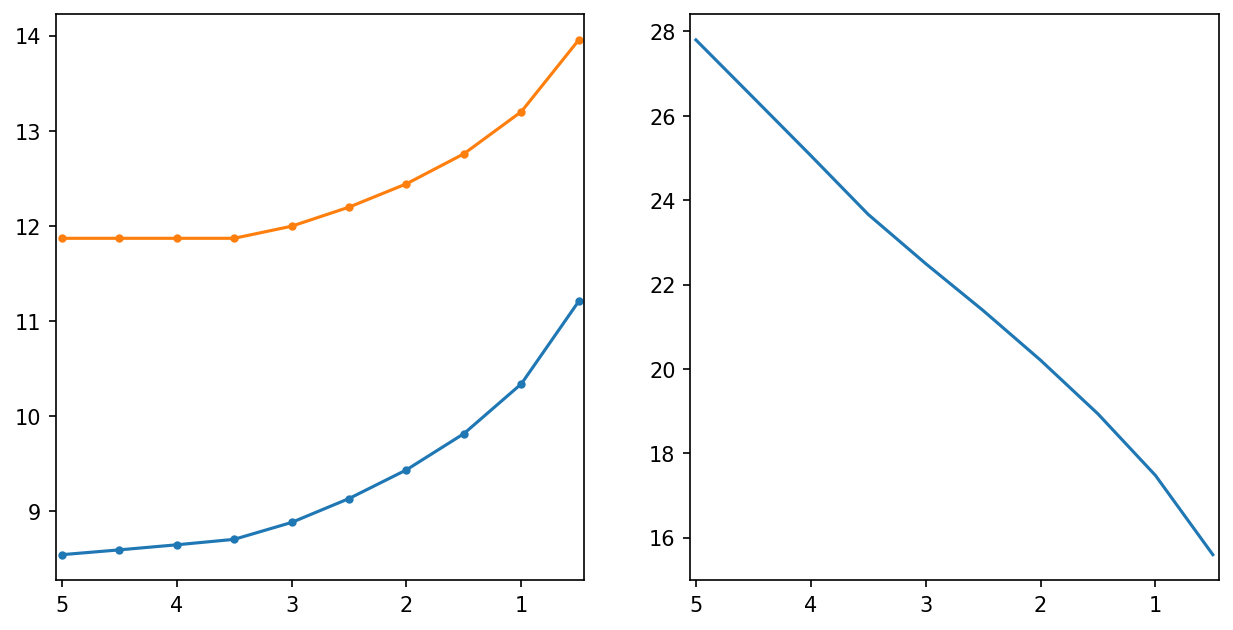

(20562, 12428)


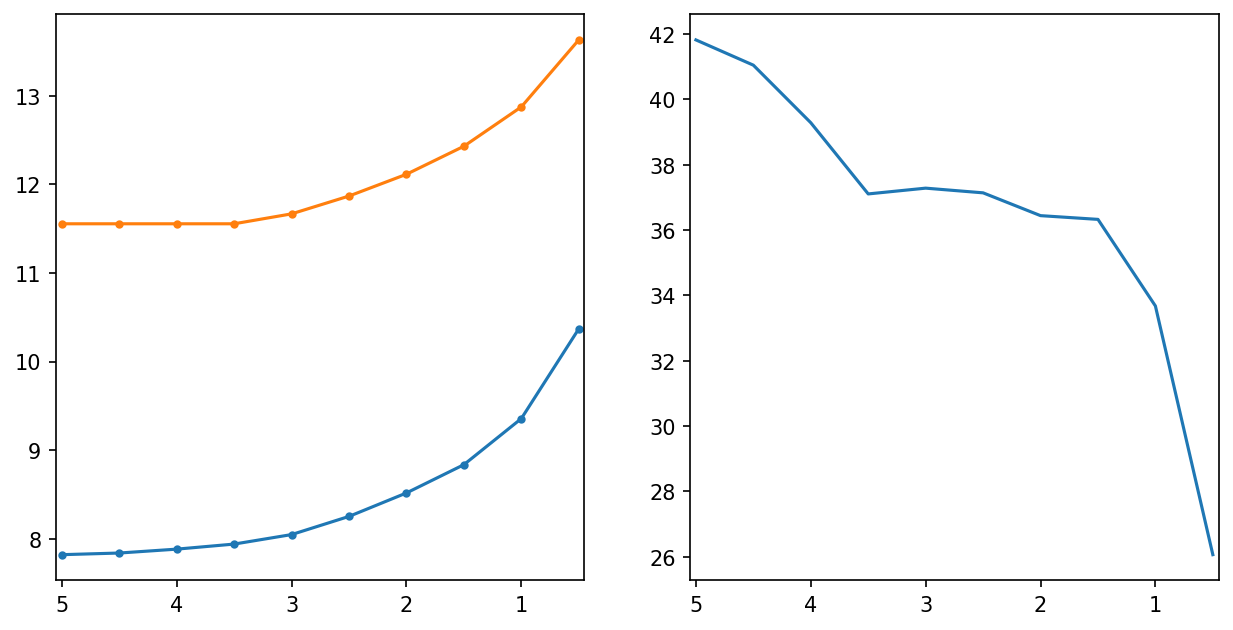

(2564, 12380)


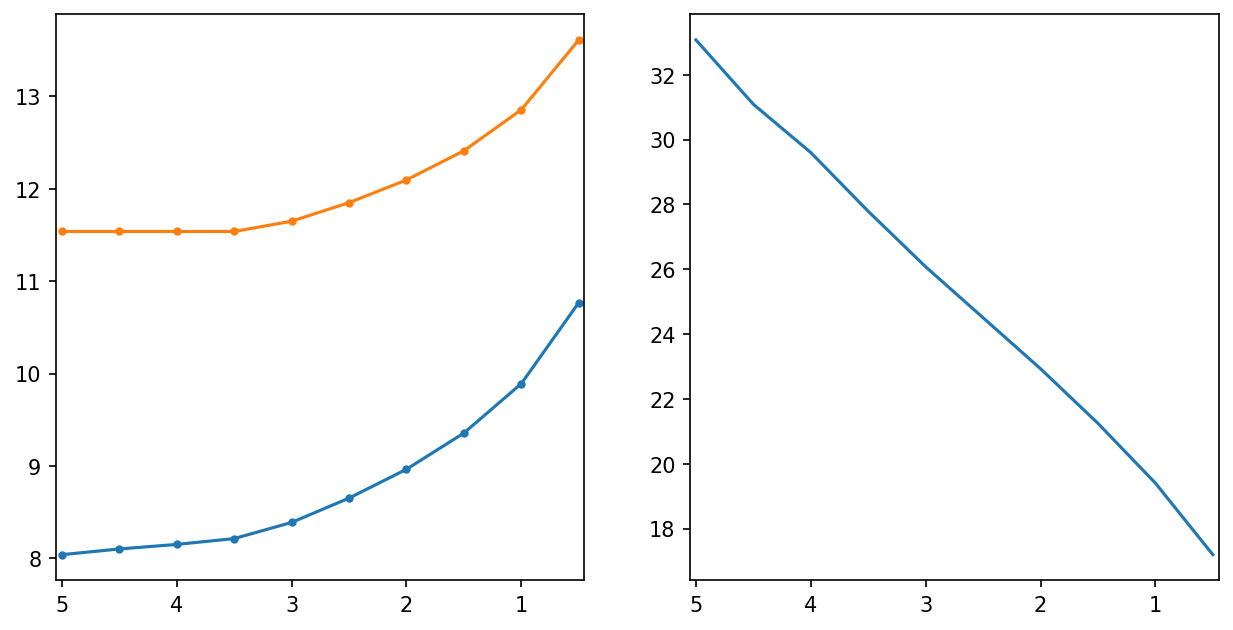

(48485, 7605)


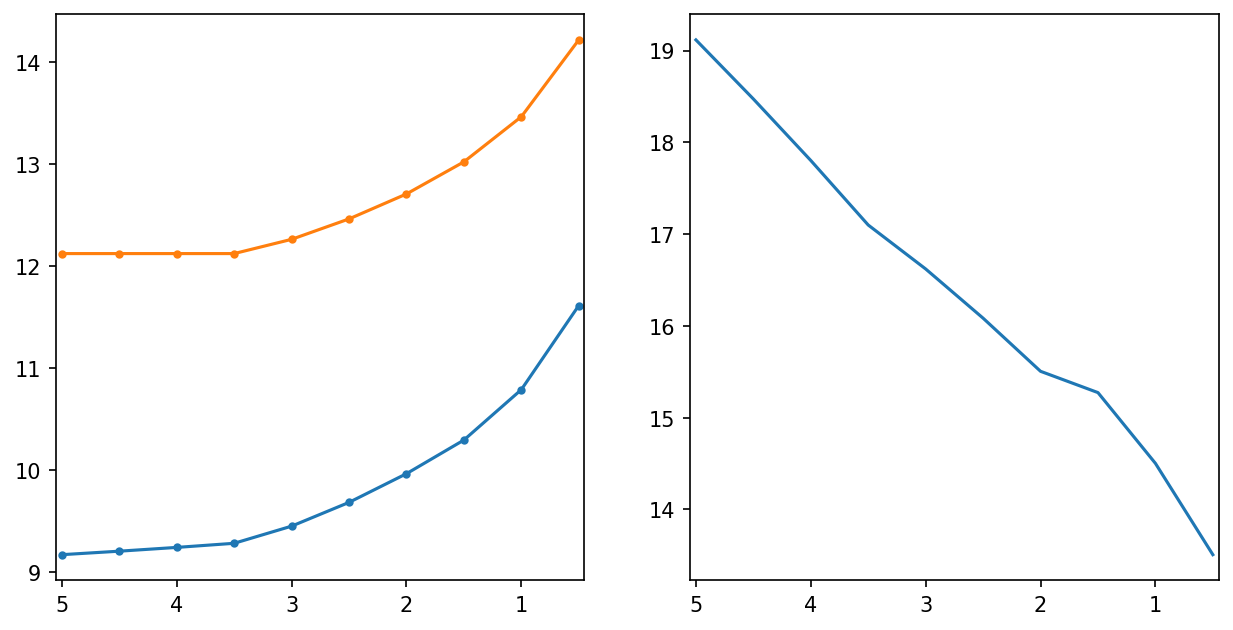

(26428, 42698)


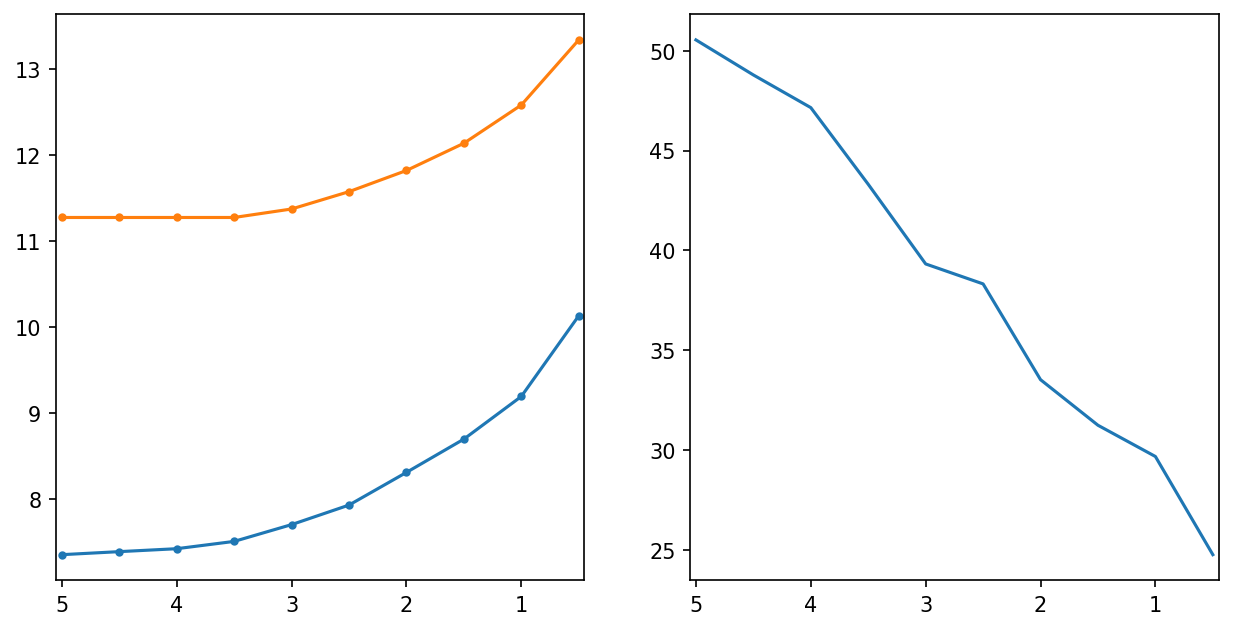

(6152, 25061)


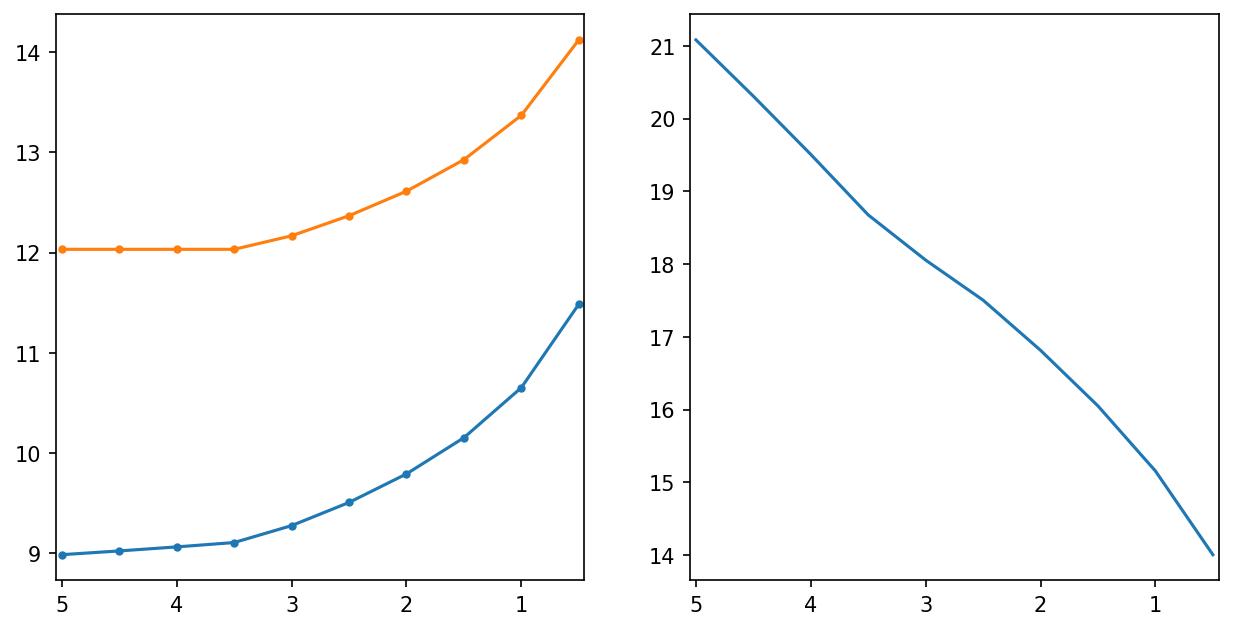

(13168, 7506)


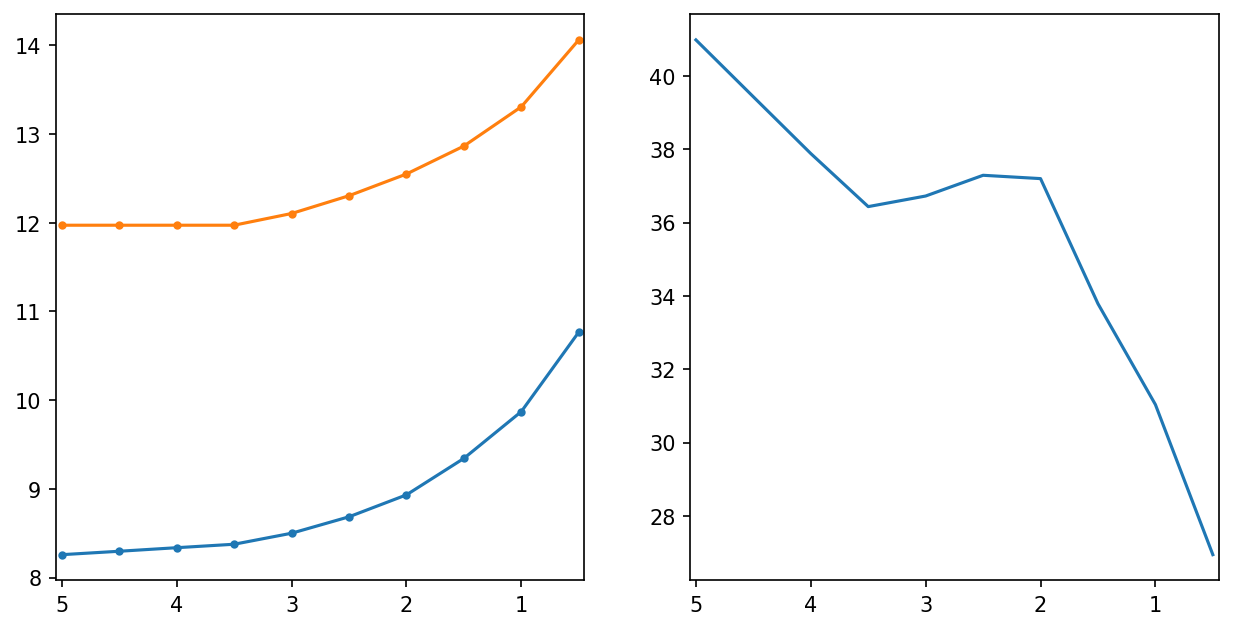

(40816, 39370)


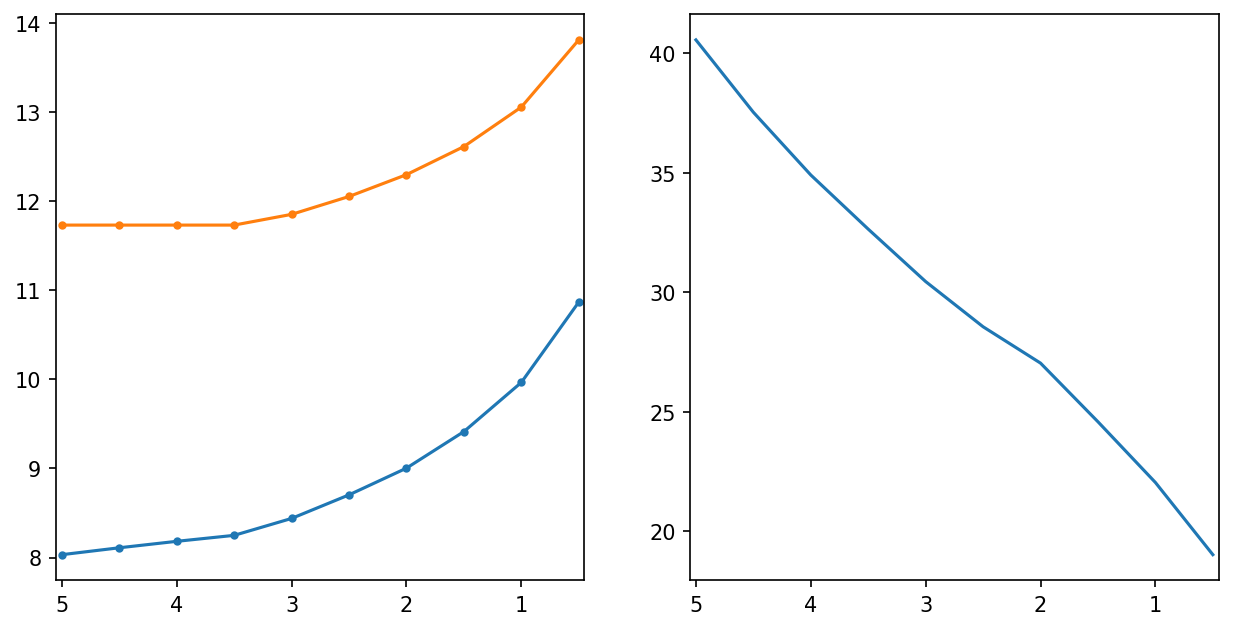

(846, 16727)


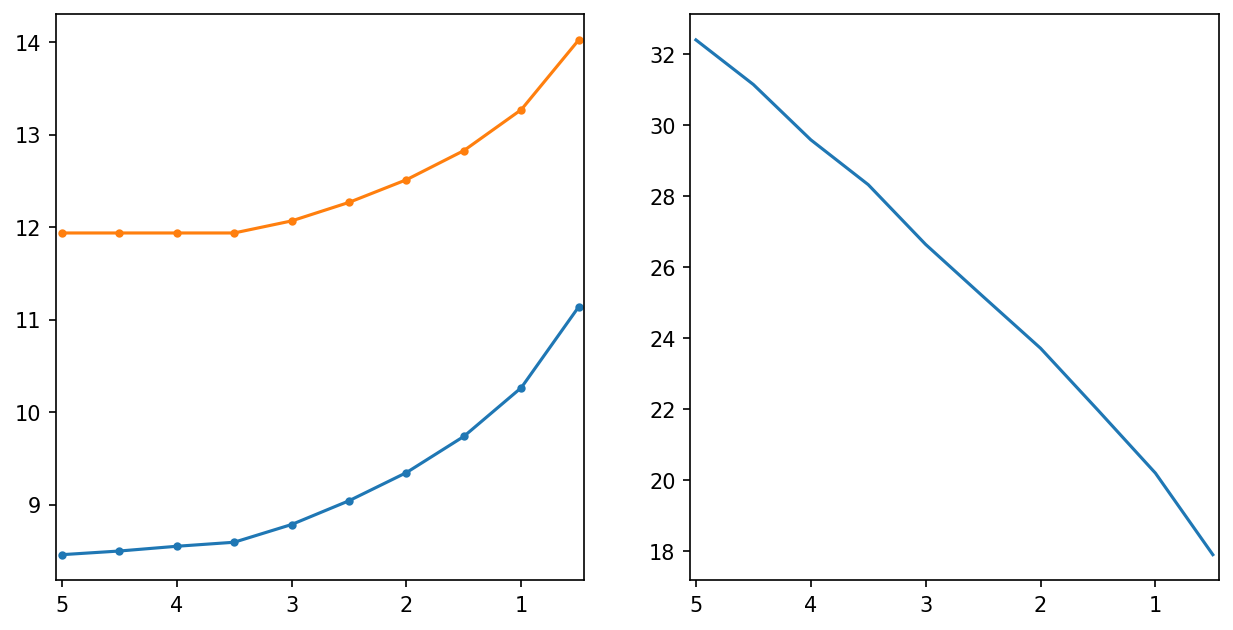

(31169, 7144)


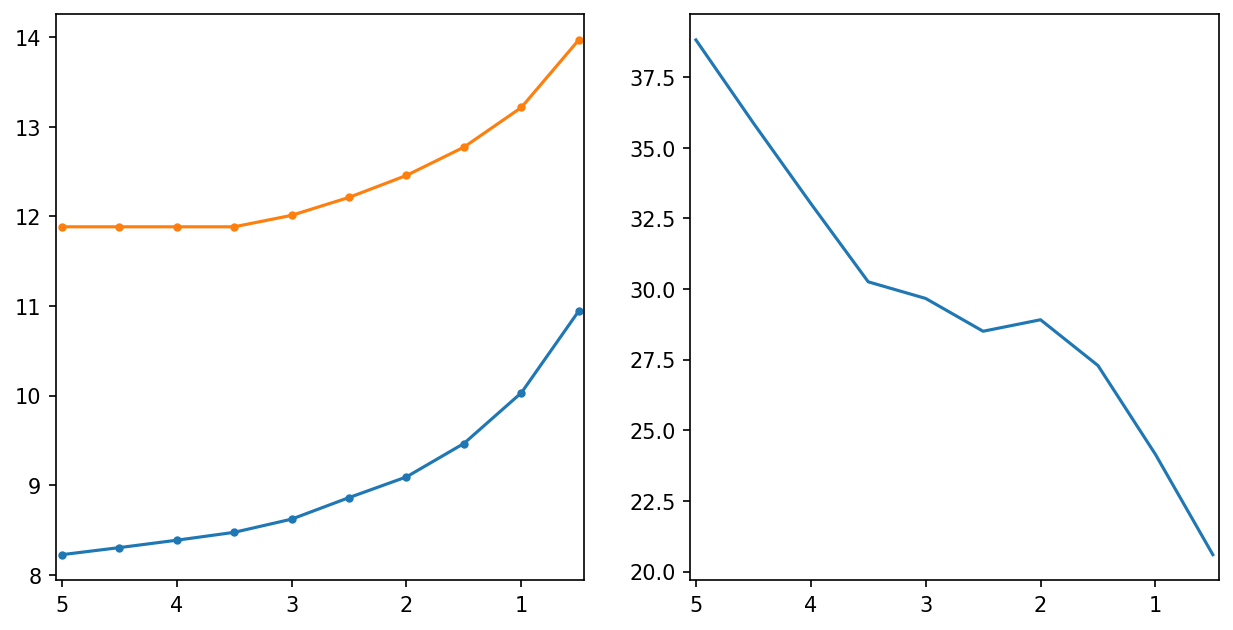

In [10]:
for i, (kc, kf) in enumerate(zip(kcs, kfs)):
    print(pairs[i])
    
    fig, ax = plt.subplots(1, 2, figsize=(10, 5), dpi=150)

    ax[0].plot(eps_arr, np.log(kc), marker='.', label='$\log k_c$')
    ax[0].plot(eps_arr, np.log(kf), marker='.', label='$\log k_f$')
    ax[0].set_xlim(5.0 + 0.05, 0.5 - 0.05)

    ax[1].plot(eps_arr, kf / kc, label='$k_f$ / $k_c$')
    ax[1].set_xlim(5.0 + 0.05, 0.5 - 0.05)

    plt.show()